In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loading train_transaction data
train_transaction = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
print(train_transaction.shape)
train_transaction = reduce_mem_usage(train_transaction)

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


In [4]:
# Loading train_identity data
train_identity = pd.read_csv('ieee-fraud-detection/train_identity.csv')
print(train_identity.shape)
train_identity = reduce_mem_usage(train_identity)

(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%


In [5]:
# Merging transaction and identity train data
train_df = pd.merge(train_transaction, train_identity, how='left')
print(train_df.shape)
len_train_df = len(train_df)
del train_transaction, train_identity
train_df.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
# Loading test_transaction data
test_transaction = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
print(test_transaction.shape)
test_transaction = reduce_mem_usage(test_transaction)


(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%


In [7]:
# Loading test_identity data
test_identity = pd.read_csv('ieee-fraud-detection/test_identity.csv')
print(test_identity.shape)
test_identity = reduce_mem_usage(test_identity)

(141907, 41)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.86 MB
Decreased by 77.8%


In [8]:
# Merging transaction and identity test data
test_df = pd.merge(test_transaction, test_identity, how='left')
test_df.columns = train_df.drop('isFraud', axis=1).columns
print(test_df.shape)
del test_transaction, test_identity
test_df.head()

(506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Missing values check
combined_df = pd.concat([train_df.drop(columns=['isFraud', 'TransactionID']), test_df.drop(columns='TransactionID')])
# Dependent variable
y = train_df['isFraud']
print(y.shape)

(590540,)


In [10]:
# Lets check if dataframe contains any null value.
# combined_df.isnull().values.any()

In [11]:
# print(combined_df.shape)

In [12]:
# Dropping columns with more than 20% missing values 
mv = combined_df.isnull().sum()/len(combined_df)
combined_mv_df = combined_df.drop(columns=mv[mv>0.2].index)
del combined_df, train_df, test_df
print(combined_mv_df.shape)

(1097231, 180)


In [13]:
# combined_mv_df.isnull().values.any()

In [14]:
# Filtering numerical data
num_mv_df = combined_mv_df.select_dtypes(include=np.number)
print(num_mv_df.shape)

# Filtering categorical data
cat_mv_df = combined_mv_df.select_dtypes(exclude=np.number)
print(cat_mv_df.shape)
del combined_mv_df

# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_mv_df), columns=num_mv_df.columns)
del num_mv_df
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_mv_df), columns=cat_mv_df.columns)
del cat_mv_df
print(cat_df.shape)

# Concatinating numerical and categorical data
combined_df_cleaned = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

# Verifying missing values
print(f'Total missing values: {combined_df_cleaned.isnull().sum().sum()}')
print(combined_df_cleaned.shape)
combined_df_cleaned.head()

(1097231, 176)
(1097231, 4)
(1097231, 176)
(1097231, 4)
Total missing values: 0
(1097231, 180)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V316,V317,V318,V319,V320,V321,ProductCD,card4,card6,P_emaildomain
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0.0,117.0,0.0,0.0,0.0,0.0,W,discover,credit,gmail.com
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,mastercard,credit,gmail.com
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,outlook.com
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,50.0,1404.0,790.0,0.0,0.0,0.0,W,mastercard,debit,yahoo.com
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,mastercard,credit,gmail.com


In [15]:
# One-hot encoding
combined_df_encoded = pd.get_dummies(combined_df_cleaned, drop_first=True)
print(combined_df_encoded.shape)
del combined_df_cleaned
combined_df_encoded.head()

(1097231, 245)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Separating train and test data
X = combined_df_encoded.iloc[:len_train_df]
print(X.shape)
test = combined_df_encoded.iloc[len_train_df:]
print(test.shape)
del combined_df_encoded

(590540, 245)
(506691, 245)


In [17]:
# Time-based train validation splitting with 20% data in validation set
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']
splitting_index = int(0.8*len(X))
X_train = X.iloc[:splitting_index].values
X_val = X.iloc[splitting_index:].values
y_train = y.iloc[:splitting_index].values
y_val = y.iloc[splitting_index:].values
test = test.values
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del y, train

(472432, 245) (118108, 245) (472432,) (118108,)


In [18]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)
# del X_train, X_val, test

# Class imbalance check
pd.value_counts(y_train)

0    455833
1     16599
dtype: int64

In [19]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(X_train_smote.shape, y_train_smote.shape)

del X_train_scaled
pd.value_counts(y_train_smote)


(911666, 245) (911666,)


1    455833
0    455833
dtype: int64

In [20]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(X_train_sm.shape, y_train_sm.shape)
pd.value_counts(y_train_sm)

(911666, 245) (911666,)


1    455833
0    455833
dtype: int64

## Model Development

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight="balanced")
lr_model = lr.fit(X_train_smote, y_train_smote)

In [22]:
y_fit_lr = lr_model.predict(X_train_smote)

In [23]:
y_pred_lr = lr_model.predict(X_val_scaled)

In [24]:
print(lr.score(X_val_scaled, y_val))

0.674797642835371


In [25]:
from sklearn.metrics import classification_report

print("Classification Report:\n\n", classification_report(y_val, y_pred_lr))

Classification Report:

               precision    recall  f1-score   support

           0       0.99      0.67      0.80    114044
           1       0.08      0.79      0.14      4064

    accuracy                           0.67    118108
   macro avg       0.53      0.73      0.47    118108
weighted avg       0.96      0.67      0.78    118108



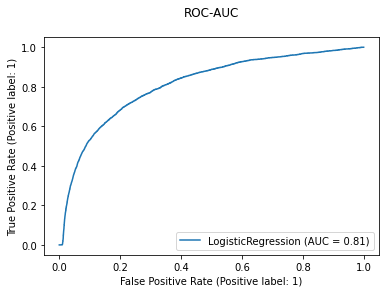

In [26]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(lr_model, X_val_scaled, y_val)
plt.title('ROC-AUC\n')
plt.show()

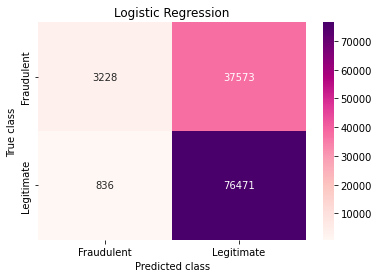

 The result is telling us that we have:  79699 correct predictions
 We have:  38409 incorrect predictions
 And a total predictions of:  118108


In [27]:
from utile import *
confusionMatrix(y_pred_lr, y_val, "Logistic Regression")

In [28]:
from math import sqrt

from sklearn.metrics import mean_squared_error


rmse = sqrt(mean_squared_error(y_val, y_pred_lr))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.570


In [29]:
# MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(y_val, y_pred_lr))
print('MSE:', metrics.mean_squared_error(y_val, y_pred_lr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_pred_lr)))

MAE: 0.325202357164629
MSE: 0.325202357164629
RMSE: 0.5702651639059052


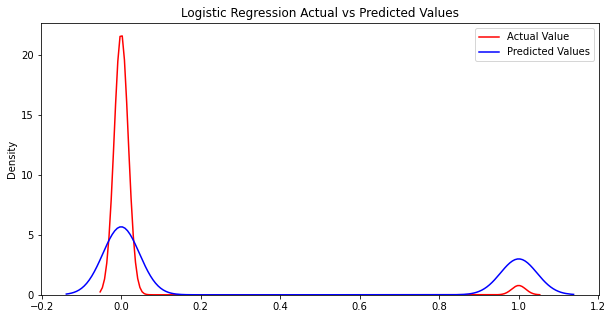

In [30]:
import seaborn as sns
plt.figure(figsize=(10, 5))


ax = sns.distplot(y_val, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred_lr, hist=False, color="b", label="Predicted Values" , ax=ax)
plt.title('Logistic Regression Actual vs Predicted Values')
plt.legend()
plt.show()
plt.close()

In [31]:
df=pd.DataFrame({'Actual':y_val, 'Predicted':y_pred_lr})
df

,Actual,Predicted
0,1,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
118103,0,0
118104,0,0
118105,0,0
118106,0,1


## XGBoost

In [32]:
import xgboost

m2_xgb = xgboost.XGBClassifier()

In [33]:
m2_xgb.fit(X_train_smote, y_train_smote)

[13:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_predicted_xgb = m2_xgb.predict(X_val_scaled)

In [35]:
print("Classification Report:\n\n", classification_report(y_val, y_predicted_xgb))

Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99    114044
           1       0.70      0.35      0.47      4064

    accuracy                           0.97    118108
   macro avg       0.84      0.67      0.73    118108
weighted avg       0.97      0.97      0.97    118108



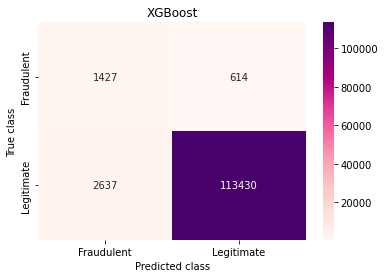

 The result is telling us that we have:  114857 correct predictions
 We have:  3251 incorrect predictions
 And a total predictions of:  118108


In [36]:
confusionMatrix(y_predicted_xgb, y_val, "XGBoost")

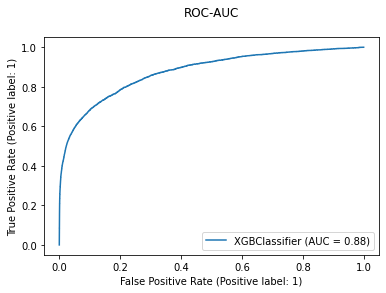

In [37]:
plot_roc_curve(m2_xgb, X_val_scaled, y_val)
plt.title('ROC-AUC\n')
plt.show()

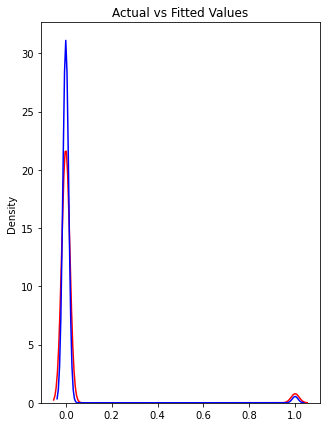

In [38]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_val, hist=False, color="r", label="Actual Value")
sns.distplot(y_predicted_xgb, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [56]:
# MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(y_val, y_predicted_xgb))
print('MSE:', metrics.mean_squared_error(y_val, y_predicted_xgb))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_predicted_xgb)))

MAE: 0.02752565448572493
MSE: 0.02752565448572493
RMSE: 0.16590857267098927


## Random Forest

In [39]:
# Random Forest Classifier
rfc = RandomForestClassifier()#criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80

In [40]:
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [41]:
y_predproba = rfc.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

Validation AUC=0.8847911533557846


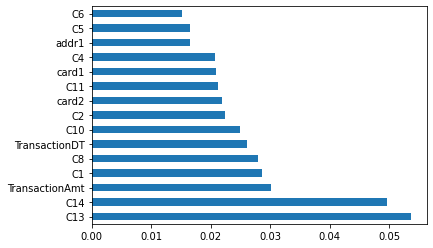

In [42]:
# Feature importances
pd.Series(rfc.feature_importances_, index=X.columns).nlargest(15).plot(kind='barh')
plt.show()

In [43]:
# Predicting for the test data 
predictions = rfc.predict_proba(test_scaled)


In [44]:
y_predicted_rfc = rfc.predict(X_val_scaled)

In [45]:
print("Classification Report:\n\n", classification_report(y_val, y_predicted_rfc))

Classification Report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.73      0.33      0.46      4064

    accuracy                           0.97    118108
   macro avg       0.85      0.66      0.72    118108
weighted avg       0.97      0.97      0.97    118108



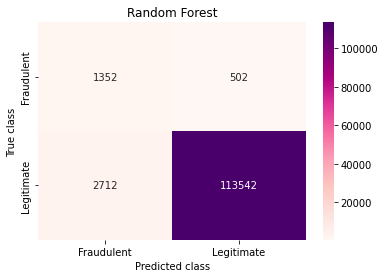

 The result is telling us that we have:  114894 correct predictions
 We have:  3214 incorrect predictions
 And a total predictions of:  118108


In [46]:
confusionMatrix(y_predicted_rfc, y_val, "Random Forest")

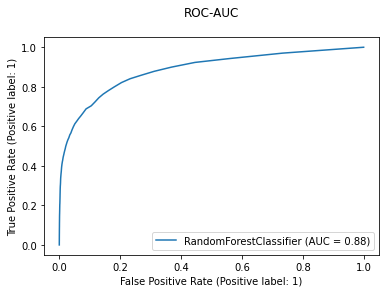

In [47]:
plot_roc_curve(rfc, X_val_scaled, y_val)
plt.title('ROC-AUC\n')
plt.show()

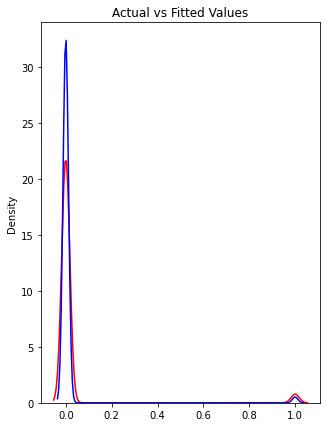

In [48]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_val, hist=False, color="r", label="Actual Value")
sns.distplot(y_predicted_rfc, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [57]:
# MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(y_val, y_predicted_rfc))
print('MSE:', metrics.mean_squared_error(y_val, y_predicted_rfc))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_predicted_rfc)))

MAE: 0.027212381887763742
MSE: 0.027212381887763742
RMSE: 0.1649617588647858


## LGBM

In [49]:
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier()
lgbm.fit(X_train_smote, y_train_smote)

LGBMClassifier()

In [50]:
# Predicting the Target variable
lgbm_pred = lgbm.predict(X_val_scaled)
print(lgbm_pred)
accuracy = lgbm.score(X_val_scaled, y_val)
print(accuracy)

[0 0 0 ... 0 0 0]
0.9678683916415484


In [51]:
from sklearn.metrics import classification_report

print("Classification Report:\n\n", classification_report(y_val, lgbm_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.98    114044
           1       0.54      0.40      0.46      4064

    accuracy                           0.97    118108
   macro avg       0.76      0.69      0.72    118108
weighted avg       0.96      0.97      0.97    118108



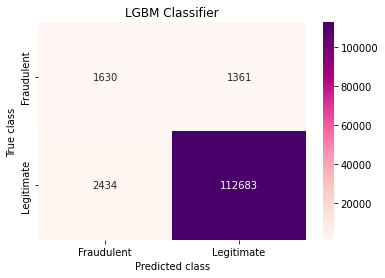

 The result is telling us that we have:  114313 correct predictions
 We have:  3795 incorrect predictions
 And a total predictions of:  118108


In [52]:
from utile import *
confusionMatrix(lgbm_pred, y_val, "LGBM Classifier")

In [53]:
from math import sqrt

from sklearn.metrics import mean_squared_error


rmse3 = sqrt(mean_squared_error(y_val, lgbm_pred))
print('Test RMSE: %.3f' % rmse3)

Test RMSE: 0.179


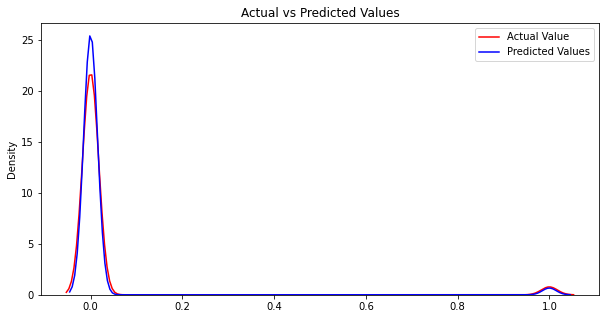

In [54]:
import seaborn as sns
plt.figure(figsize=(10, 5))


ax = sns.distplot(y_val, hist=False, color="r", label="Actual Value")
sns.distplot(lgbm_pred, hist=False, color="b", label="Predicted Values" , ax=ax)


plt.title('Actual vs Predicted Values')

plt.legend()
plt.show()
plt.close()

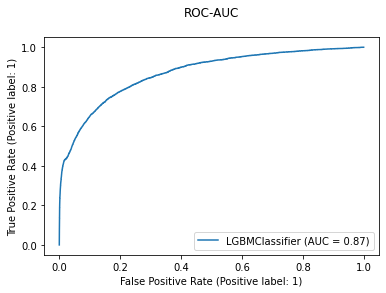

In [55]:
plot_roc_curve(lgbm, X_val_scaled, y_val)
plt.title('ROC-AUC\n')
plt.show()

In [59]:
from sklearn.metrics import log_loss  
# where y_pred are probabilities and y_true are binary class labels
log_loss(y_val, lgbm_pred, eps=1e-15)

1.109795650343657

In [58]:
# MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(y_val, lgbm_pred))
print('MSE:', metrics.mean_squared_error(y_val, lgbm_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, lgbm_pred)))

MAE: 0.03213160835845159
MSE: 0.03213160835845159
RMSE: 0.1792529172941171
